# GoDaddy - Microbusiness Density Forecasting

合併census data
異常檢測
時間序列資料切分訓練、測試資料集的方法
ensemble model (Stacking model)




In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
BASEPATH = 'data\\'

In [16]:
train = pd.read_csv(BASEPATH + 'train.csv')
test = pd.read_csv(BASEPATH + 'test.csv')
census = pd.read_csv(BASEPATH +'census_starter.csv')

In [17]:
data = pd.concat([train, test])
print(train.shape)
print(data.shape)

(122265, 7)
(147345, 7)


In [18]:
# Convert data type
data['first_day_of_month'] = pd.to_datetime(data['first_day_of_month'])
# test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])

## 使用差分(Differencing)來做序列平穩，並且做異常值檢測

In [19]:
lag = 1
Anomaly_TH = 0.2

Text(0.5, 1.0, 'Before smoothing')

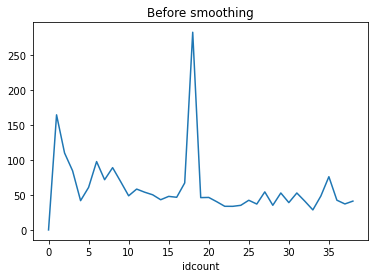

In [20]:
# Get index 0 ~ 38 for each cfip
train['idcount'] = train.groupby(['cfips'])['row_id'].cumcount()

# The microbusiness density increase percentage
train['MBD_change'] = train.groupby('cfips')['microbusiness_density'].pct_change(lag).fillna(0)

# We found inf value, so check for whether a divide zero situation.
idx_for_inf = train[train['MBD_change']==np.inf].index
# If so, MBD_change set to 1
if train.loc[idx_for_inf - 1, 'microbusiness_density'].all() == 0:
    train.loc[idx_for_inf, 'MBD_change'] = 1

train['MBD_change'] = train['MBD_change'].abs()


original = train.groupby('idcount')['MBD_change'].sum()
original.plot()
plt.title('Before smoothing')

我們觀察出序列18的百分比變化較大

In [24]:
cfips_list = data['cfips'].unique()

### outlier 處理

In [25]:
outliers = []   # record which cfips has outliners
cnt = 0         # the tot num of outliners

# We iter for all cfip
for cfip in tqdm(cfips_list):

    indices = train['cfips']==cfip  # get all the idx for each cfip
    tmp = train.loc[indices].copy().reset_index(drop=True)  # remember to reset index
    var = tmp.microbusiness_density.values.copy()  # copy density data for the current cfips

    for i in range(38, 1, -1):  # I think it only makes sense to do from the fourth value
        thr = Anomaly_TH * np.mean(var[:i])    # use 20% average of the points before current point i as the anomaly value TH
        difa = abs(var[i] - var[i-1])      # if the current point i's increment is bigger than thr, we consider it as a anomaly change, not natural trend
        if (difa >= thr):                  # so we 'lift' all the previous values to the same 'stage' of the current point
            if (var[i-1] != 0):
                var[:i] *= (var[i] / var[i-1])
            outliers.append(cfip)         # save which cfips has outliers
            cnt+=1                     # total count

    train.loc[indices, 'microbusiness_density'] = var  # the smoothed density
outliers = np.unique(outliers)
print(f'------------------------------')
print(f'there are {len(outliers)} county have {cnt} outliners in total.')
print(f'------------------------------')




100%|██████████| 3135/3135 [00:09<00:00, 315.84it/s]

------------------------------
there are 489 county have 804 outliners in total.
------------------------------


In [26]:
train['microbusiness_density'].isna().sum()

0

### 異常值檢測

In [27]:
# Get index 0 ~ 38 for each cfip
train['idcount'] = train.groupby(['cfips'])['row_id'].cumcount()

# The microbusiness density increase percentage
train['MBD_change'] = train.groupby('cfips')['microbusiness_density'].pct_change(lag).fillna(0)

# We found inf value, so check for whether a divide zero situation.
idx_for_inf = train[train['MBD_change']==np.inf].index
# If so, MBD_change set to 1
if train.loc[idx_for_inf - 1, 'microbusiness_density'].all() == 0:
    train.loc[idx_for_inf, 'MBD_change'] = 1

train['MBD_change'] = train['MBD_change'].abs()


after = train.groupby('idcount')['MBD_change'].sum()

train = train.drop(['idcount','MBD_change'], axis=1)

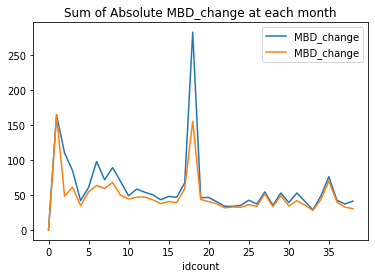

In [28]:
original.plot()
after.plot()
plt.title('Sum of Absolute MBD_change at each month')
plt.legend()
plt.show()

## Join Census and Training data

In [29]:
# 新增 year 欄位，用來與census 的資料做 merge
data['year'] = data['first_day_of_month'].dt.year
# test['year'] = test['first_day_of_month'].dt.year

In [30]:
census.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

Split census data to 5 dataframes

In [31]:
bb_col = ['cfips', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021']
college_col = ['cfips', 'pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021']
foreign_born = ['cfips', 'pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021']
it_workers_col = ['cfips', 'pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021']
hh_inc_col = ['cfips', 'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019','median_hh_inc_2020', 'median_hh_inc_2021']

pct_bb = census[bb_col]
pct_college = census[college_col]
pct_foreign_born = census[foreign_born]
pct_it_workers = census[it_workers_col]
median_hh_inc = census[hh_inc_col]

Split census data to 5 dataframes

下面這一段主要的工作是：

先將dataframe melt 成適合與train data join的形式 (透過'cfip'和'year'為key)，並且處理這些指標皆有兩年滯後的問題，最後再一一的將這些資料框與train join起來

In [32]:
import re
dfs = [pct_bb, pct_college, pct_foreign_born, pct_it_workers, median_hh_inc]  # census data 
col_names = [bb_col, college_col, foreign_born, it_workers_col, hh_inc_col]
value_names = ['pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc']

# Melt df to format that we need
for i, (df, col_name, value_name) in enumerate(zip(dfs, col_names, value_names)):
    df = pd.melt(df, id_vars=['cfips'], value_vars=col_name, var_name='year', value_name=value_name)
    df['year'] = df['year'].apply(lambda x: re.findall('\d+', x)[0]).astype(int)
    df['year'] = df['year'] + 2  # Because there are two years lag to match microbusiness
    dfs[i] = df
    
    data = data.merge(df, how='left', on=['cfips', 'year'])
    # test = test.merge(df, how='left', on=['cfips', 'year'])

# re-assign
pct_bb, pct_college, pct_foreign_born, pct_it_workers, median_hh_inc = dfs



## 前處理

Missing Value

In [33]:
data.isna().sum()

row_id                       0
cfips                        0
county                   25080
state                    25080
first_day_of_month           0
microbusiness_density    25080
active                   25080
year                         0
pct_bb                       0
pct_college                  0
pct_foreign_born             0
pct_it_workers              12
median_hh_inc               30
dtype: int64

25080為test的資料筆數因此缺失為正常。

census欄位缺失值數量並不多，且一個clips最多也才5年的資料，並不是適合用複雜的方式填補缺失值，因此我們使用forward fill來處理Missing value

In [34]:
# Fillna
data['pct_it_workers'] = data['pct_it_workers'].fillna(method='ffill')
data['median_hh_inc'] = data['median_hh_inc'].fillna(method='ffill')

共有3135個cfips

In [35]:
cfips_list = data['cfips'].unique()
n_cfips = data['cfips'].nunique() # 3135
n_cfips

3135

每個cfips的時間長度都為47

In [36]:
sum(data['cfips'].value_counts().sort_index() != 47)

0

## 準備訓練、測試資料
    以前兩年的資料來預測下一個月的資料

- **Training date**: from 2019-08-01 to 2022-06-01
- **Talidation date**: 2022-08 2022-09
- **Testing date**: 2022-10-01

- **Forcast date**: from 2022-11 to 2023-06

在處理三維資料時需要謹慎處理維度之間的轉換

In [37]:
total_time_point = 47  # From 2019-08-01 to 2023-06
time_length = 39  # Training data from 2019-08-01 to 2023-06
time_step = 24  # 2-year
validation_month = 2

train_x = np.zeros((1, 5, time_step))
val_x = np.zeros((1, 5, time_step))
test_x = np.zeros((1, 5, time_step))
test_data_x = np.zeros((1, 5, time_step))


train_y = []
val_y = []
test_y = []

test_dict = defaultdict()  # the "Real" Test data (for submission)



In [38]:
for cfip in tqdm(cfips_list):
    df = data[data['cfips'] == cfip][['microbusiness_density', 'pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers']].reset_index(drop=True)
    
    for i in range(total_time_point - time_step):
        
        # Prepare Training data
        if i < (time_length - time_step - validation_month - 1):
            train_x = np.concatenate((train_x, df.loc[i:i + time_step - 1].values.T.reshape(1, 5, time_step)), axis=0)
            train_y.append(df['microbusiness_density'].loc[i+time_step])

        # Prepare Validation data
        elif i < (time_length - time_step - 1):
            val_x = np.concatenate((val_x, df.loc[i:i + time_step - 1].values.T.reshape(1, 5, time_step)), axis=0)
            val_y.append(df['microbusiness_density'].loc[i+time_step])
        
        # Prepare Testing data
        elif i == (time_length - time_step - 1):
            test_x = np.concatenate((test_x, df.loc[i:i + time_step - 1].values.T.reshape(1, 5, time_step)), axis=0)
            test_y.append(df['microbusiness_density'].loc[i+time_step])            

        # Real Testing data
        else:
            test_data_x = np.concatenate((test_data_x, df.loc[i:i + time_step - 1].values.T.reshape(1, 5, time_step)), axis=0)  

        # # we create "Real" test data here
        # if (i + 1) == time_length - time_step:
        #     test_dict[cfip] = df['microbusiness_density'].loc[(i + 1):(i + 1) + time_step - 1].values

100%|██████████| 3135/3135 [11:28<00:00,  4.55it/s]


In [39]:
# We need to do some transpose to our data
train_x = train_x[1:, :, :].transpose(0, 2, 1)
val_x = val_x[1:, :, :].transpose(0, 2, 1)
test_x = test_x[1:, :, :].transpose(0, 2, 1)
test_data_x = test_data_x[1:, :, :].transpose(0, 2, 1)

train_y = np.asarray(train_y)
val_y = np.asarray(val_y)
test_y = np.asarray(test_y)

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(test_data_x.shape)

(37620, 24, 5)
(6270, 24, 5)
(3135, 24, 5)
(25080, 24, 5)


# Use Ensemble Model (Stacking)

**在Stacking中，第二層的meta-model通常選擇簡單的模型，如線性回歸、決策樹等，主要有以下幾個原因：**

1. 避免過擬合：第二層的meta-model通常使用的是較簡單的模型，因為複雜的模型容易過擬合，尤其是當第一層的模型數量較多時。如果meta-model也選擇了一個複雜的模型，就會增加過擬合的風險。簡單的模型則具有較強的泛化能力，可以更好地應對未知的數據。

2. 計算效率高：第一層的模型可以是任何模型，包括神經網絡等複雜的模型，而第二層的meta-model只需要使用第一層的輸出結果進行訓練。簡單的模型通常具有較高的計算效率，可以更快地進行訓練和預測。

3. 解釋性強：簡單的模型通常具有較強的解釋性，可以更好地理解模型對結果的影響。這在一些應用場景中非常重要，例如金融領域中的信用評分等。

In [12]:
import xgboost as xgb
from keras.layers import GRU, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import tensorflow as tf

c:\Users\Yicheng\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### First Step: 調用tf.keras.losses.Loss 類來自定義損失函數－SMAPE

In [13]:
# Definte loss
class SMAPE(tf.keras.losses.Loss):
    def __init__(self, name='smape_loss', **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        epsilon = 0.1
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
        smape = K.abs(y_pred - y_true) / summ * 2.0
        return smape    

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

### Step 2: 我們嘗試使用 Decay Learning Rate:
Step Decay Math Formula:

lr = lr0 * drop^floor(epoch / epochs_drop)

In [14]:
import math
from tensorflow.keras.callbacks import LearningRateScheduler

In [141]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop=0.5
    epochs_drop=10.0
    lrate = initial_lrate * math.pow(drop,
                                    math.floor((1+epoch)/(epochs_drop)))
    return lrate

lrate = LearningRateScheduler(step_decay)

### Step 3: Build GRU Model

In [142]:
from tensorflow.keras.models import load_model
import keras

In [146]:
# Build Keras model
model = Sequential()
model.add(GRU(32, input_shape = (train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam',
             loss=SMAPE(),
             metrics=SMAPE())

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 24, 32)            3744      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


**Use keras.callbacks to do EarlyStopping, CheckPoint, learning rate rdecay**

In [147]:
# Create callbacks_list in order to pass "callbacks"
callbacks_list = [EarlyStopping(monitor='smape_loss',
                 patience=5),
                 
                 ModelCheckpoint(filepath='gru_model.h5',
                                monitor='smape_loss',
                                 save_best_only=True),
                                 
                 lrate]

In [148]:
# train Keras Model
history = model.fit(train_x,
                   train_y,
                   epochs=100,
                   batch_size=64,
                   validation_data=(val_x, val_y),
                   callbacks=callbacks_list)


Epoch 1/100
588/588 [==============================] - 13s 16ms/step - loss: 0.2639 - smape_loss: 0.2639 - val_loss: 0.1412 - val_smape_loss: 0.1412 - lr: 0.0010
Epoch 2/100
588/588 [==============================] - 9s 15ms/step - loss: 0.1354 - smape_loss: 0.1354 - val_loss: 0.0931 - val_smape_loss: 0.0931 - lr: 0.0010
Epoch 3/100
588/588 [==============================] - 9s 14ms/step - loss: 0.1166 - smape_loss: 0.1166 - val_loss: 0.0498 - val_smape_loss: 0.0498 - lr: 0.0010
Epoch 4/100
588/588 [==============================] - 8s 14ms/step - loss: 0.1049 - smape_loss: 0.1049 - val_loss: 0.0567 - val_smape_loss: 0.0568 - lr: 0.0010
Epoch 5/100
588/588 [==============================] - 9s 16ms/step - loss: 0.0965 - smape_loss: 0.0965 - val_loss: 0.0480 - val_smape_loss: 0.0480 - lr: 0.0010
Epoch 6/100
588/588 [==============================] - 9s 15ms/step - loss: 0.0883 - smape_loss: 0.0883 - val_loss: 0.0562 - val_smape_loss: 0.0563 - lr: 0.0010
Epoch 7/100
588/588 [============

In [217]:
# model = load_model('1.79\gru_model.h5', compile=False)

**Check Loss Curve**

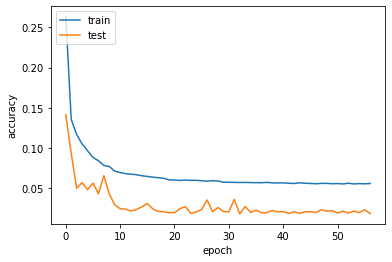

In [271]:
plt.plot(history.history['smape_loss'])
plt.plot(history.history['val_smape_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### multi-step ahead 預測
    這段程式碼的目的是進行 multi-step ahead 預測，其中 test_data_x 是測試集的輸入數據，model 是訓練好的模型。整個循環運行了 8 次，每次Loop選擇一個起始時間步，從 test_data_x 中選擇對應時間步的數據，使用模型進行預測，然後將預測結果放回到 test_data_x 中，用於下一次迭代。

In [457]:
test_data_x = np.load(r'data\test_data_x.npy')

In [458]:
# 一個test_data_x中的cfips包含8個時間點

for i in range(8):
    # print(i)
    sub_test_x = test_data_x[i::8, :, :]
    y_pred = model.predict(sub_test_x)
    # print(y_pred[:5])
    for j in range(1, 8-i):
        # print(j)
        test_data_x[(j+i)::8, -j, 0] = y_pred.reshape(-1)

In [470]:
prediction = np.append(test_data_x[7::8, -7:, 0], y_pred, axis=1)  # axis2 -7: Cuz we haven't store in test_data_x 
prediction.shape

(3135, 8)

In [473]:
test = test.sort_values(['cfips', 'first_day_of_month'])
test['microbusiness_density'] = prediction.reshape(-1)

In [476]:
test

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.443510
3135,1001_2022-12-01,1001,2022-12-01,3.424868
6270,1001_2023-01-01,1001,2023-01-01,3.405197
9405,1001_2023-02-01,1001,2023-02-01,3.385468
12540,1001_2023-03-01,1001,2023-03-01,3.355452
...,...,...,...,...
12539,56045_2023-02-01,56045,2023-02-01,1.752009
15674,56045_2023-03-01,56045,2023-03-01,1.740405
18809,56045_2023-04-01,56045,2023-04-01,1.730313
21944,56045_2023-05-01,56045,2023-05-01,1.720994


In [481]:
test.drop(['cfips', 'first_day_of_month'], axis=1).to_csv('submission.csv', index=False)

In [418]:
def smape(y_pred, y_true):
    """
    計算預測值和實際值的SMAPE

    參數：
    y_pred: numpy array，模型的預測值
    y_true: numpy array，實際值

    返回值：
    SMAPE: float，SMAPE的值
    """
    n = y_pred.shape[0]
    smape = (1/n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return smape

In [165]:
smape(y_pred.reshape(-1), test_y)

0.01835339929515102

**Hyper Parameter Tunning**

In [482]:
from sklearn.model_selection import GridSearchCV

定義模型的超參數搜索空間。我們想要調整的超參數有：GRU層的單元數量、Dropout層的比例、和Dense層的單元數量。

In [487]:
import keras_tuner
from keras_tuner import HyperModel
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

class MyHyperModel(HyperModel):
    def __init__(self, time_step):
        self.time_step = time_step

    def build(self, hp):
        model = Sequential()
        model.add(GRU(units=hp.Int('units_1', min_value=16, max_value=128, step=16), 
                      input_shape=(self.time_step, 5),
                      return_sequences=True))
        model.add(GRU(units=hp.Int('units_2', min_value=16, max_value=128, step=16), 
                      return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
        model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=128, step=16), 
                        activation='relu'))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', 
                      loss=SMAPE(), 
                      metrics=SMAPE())
        return model


創建一個 RandomSearch 對象，並使用 MyHyperModel 作為超參數優化的模型。

In [488]:
hypermodel = MyHyperModel(time_step=24)

tuner = RandomSearch(hypermodel,
                     objective='val_loss',
                     seed=17,
                     max_trials=10,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='GRU_godaddy_v2')

INFO:tensorflow:Reloading Tuner from my_dir\GRU_godaddy_v2\tuner0.json


開始搜索。調用 search() 方法開始搜索，並指定訓練數據和驗證數據。

In [489]:
es_callback = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_x, train_y, 
             epochs=100, 
             validation_data=(val_x, val_y), 
             batch_size=64,
             callbacks=[es_callback])

Trial 9 Complete [00h 04m 54s]
val_loss: 0.03221934723357359

Best val_loss So Far: 0.019784661009907722
Total elapsed time: 01h 11m 32s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
80                |80                |units_1
128               |80                |units_2
0.1               |0.1               |dropout
128               |16                |units_3

Epoch 1/100
588/588 [==============================] - 30s 47ms/step - loss: 0.1336 - smape_loss: 0.1336 - val_loss: 0.0578 - val_smape_loss: 0.0578
Epoch 2/100
588/588 [==============================] - 26s 45ms/step - loss: 0.0609 - smape_loss: 0.0609 - val_loss: 0.0439 - val_smape_loss: 0.0439
Epoch 3/100
588/588 [==============================] - 27s 45ms/step - loss: 0.0483 - smape_loss: 0.0483 - val_loss: 0.0618 - val_smape_loss: 0.0618
Epoch 4/100
588/588 [==============================] - 27s 45ms/step - loss: 0.0498 - smape_loss: 0.0498 - val_loss: 0.0653 - val_smape_loss: 0.0653
E

KeyboardInterrupt: 

獲取最佳超參數組合。調用 get_best_models() 方法可以獲取最佳模型和相應的超參數組合。

**使用 best_hp 物件中的最佳超参數值創建模型**

In [29]:
model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

### Step 4: 將 Keras 模型的預測結果與原始特徵合併

In [35]:
test_x = []
for value in test_dict.values():
    test_x.append(value)
test_x = np.array(test_x)

In [36]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

In [37]:
X_train_new = np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[1]), pred_train), axis=1)
X_val_new = np.concatenate((X_val.reshape(X_val.shape[0], X_val.shape[1]), pred_val), axis=1)

### Step 5: 使用XGBOOST 進行訓練

In [158]:
# Define objective function for XGBoost
def smape_objective(y_true, y_pred):
    """
    An XGBoost objective function for symmetric mean absolute percentage error (SMAPE).
    """
    epsilon = 0.1
    summ = np.abs(y_true) + np.abs(y_pred) + epsilon
    smape = np.abs(y_pred - y_true) / summ * 2.0
    grad = 2.0 * (y_pred - y_true) / summ / (1.0 / (np.abs(y_true) + epsilon) + 1.0 / (np.abs(y_pred) + epsilon))
    hess = 2.0 / summ / (1.0 / (np.abs(y_true) + epsilon) + 1.0 / (np.abs(y_pred) + epsilon))
    return 'smape', np.mean(smape), np.mean(grad), np.mean(hess)

# Create XGBoost model with custom loss function
params = {'objective': "reg:squarederror", 'eval_metric': smape_objective, 'max_depth': 3, 'n_estimators': 100, 'tree_method': "exact", 'n_jobs': 200}
xgb_model = xgb.XGBRegressor(**params)

In [39]:
# train XGBoost model
xgb_model.fit(X_train_new.reshape(X_train_new.shape[0], X_train_new.shape[1]), y_train,
            eval_set=[(X_val_new.reshape(X_val_new.shape[0], X_val_new.shape[1]), y_val)],
            early_stopping_rounds=20)


[0]	validation_0-rmse:5.28308
[1]	validation_0-rmse:3.84082
[2]	validation_0-rmse:2.81177
[3]	validation_0-rmse:2.06808
[4]	validation_0-rmse:1.53983
[5]	validation_0-rmse:1.16093
[6]	validation_0-rmse:0.88962
[7]	validation_0-rmse:0.69575
[8]	validation_0-rmse:0.55849
[9]	validation_0-rmse:0.46679
[10]	validation_0-rmse:0.39459
[11]	validation_0-rmse:0.34815
[12]	validation_0-rmse:0.31873
[13]	validation_0-rmse:0.29755
[14]	validation_0-rmse:0.28335
[15]	validation_0-rmse:0.27222
[16]	validation_0-rmse:0.26601
[17]	validation_0-rmse:0.25696
[18]	validation_0-rmse:0.24743
[19]	validation_0-rmse:0.24282
[20]	validation_0-rmse:0.23481
[21]	validation_0-rmse:0.23502
[22]	validation_0-rmse:0.23061
[23]	validation_0-rmse:0.22469
[24]	validation_0-rmse:0.22398
[25]	validation_0-rmse:0.22329
[26]	validation_0-rmse:0.21810
[27]	validation_0-rmse:0.21412
[28]	validation_0-rmse:0.21156
[29]	validation_0-rmse:0.21160
[30]	validation_0-rmse:0.21018
[31]	validation_0-rmse:0.20784
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function smape_objective at 0x000002247C4C2160>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=200,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

**XGB Model 超參數調教**

In [392]:
from sklearn.metrics import make_scorer

# Create the SMAPE scorer using make_scorer
smape_scorer = make_scorer(smape_objective, greater_is_better=False)


# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 200]
}
xgb_model_G = xgb.XGBRegressor(objective = "reg:squarederror", eval_metric= smape_objective, scoring=smape_scorer)

# Define the grid search
grid_search = GridSearchCV(estimator=xgb_model_G, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train_new.reshape(X_train_new.shape[0], X_train_new.shape[1]), y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Lowest SMAPE found: ", -1.0 * grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Lowest SMAPE found:  -0.9979493217533211


建立最佳模型

In [43]:
# Create XGBoost model with custom loss function
params = {'objective': "reg:squarederror", 'learning_rate': 0.1, 'eval_metric': smape_objective, 'max_depth': 6, 'n_estimators': 200, 'tree_method': "exact", 'n_jobs': -1}
xgb_model = xgb.XGBRegressor(**params).fit(X_train_new.reshape(X_train_new.shape[0], X_train_new.shape[1]), y_train)

### Step 6: 開始預測

In [40]:
for cfip in tqdm(cfips_list):
    for i in range(8):
        # Use keras model to predict
        X_test = test_dict[cfip][-time_step:].copy().reshape(1, time_step, 1)
        y_pred = model.predict(X_test)

        # Concatenate to X_test
        new_X_test = np.concatenate((X_test.reshape(time_step, 1), y_pred), axis=0)

        # past to xgb model
        ensem_y_pred = xgb_model.predict(new_X_test.reshape(1, time_step + 1))


        test_dict[cfip] = np.append(test_dict[cfip], ensem_y_pred)

100%|██████████| 3135/3135 [27:30<00:00,  1.90it/s]


In [150]:
for cfip in tqdm(cfips_list):
    for i in range(8):
        X_test = test_dict[cfip][-time_step:].copy().reshape(1, time_step, 5)
        y_pred = model.predict(X_test)
        test_dict[cfip] = np.append(test_dict[cfip], y_pred)

  0%|          | 0/3135 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 24 into shape (1,24,5)

In [32]:
# Save dict
np.save('file.npy', test_dict)

# new_dict = np.load('/kaggle/input/file-1/file (1).npy', allow_pickle='TRUE')
# print(new_dict)

In [33]:
test = test.sort_values(['cfips', 'first_day_of_month'])

In [34]:
first_key = True
for key, value in test_dict.items():    
    if first_key:
        y_pred = value[-8:]
        first_key = False
    else:
        y_pred = np.concatenate((y_pred, value[-8:]))

# target
test['microbusiness_density'] = y_pred

# write csv
test.drop(['cfips','first_day_of_month'], axis=1).to_csv('submission.csv', index=False)

In [170]:
test_data_x

(3135, 24, 5)

In [ ]:
y_predict = pd.read_csv(r'0214\submission (5).csv')

In [38]:
test = test.merge(y_predict, on='row_id')

data = pd.concat([train, test])

In [51]:
data = data.reset_index(drop=True)

In [40]:
import seaborn as sns

In [60]:
cfips_list[10]

1021

Learingrate
https://blog.csdn.net/qq_34510308/article/details/104989143